# NLP Processing with Disaster Tweets

# Competition description

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programmatically monitoring Twitter (i.e. disaster relief organizations and news agencies).<br>
In this task we have to predict whther a tweet is about a real disaster or not

# Work plan

EDA >> Data preprocessing

# Importing libraries

In [389]:
#data analysis and vizualisation libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#NLP libs
import string #lib for string operations
import nltk #natural language toolkit
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re #regex lib
from wordcloud import WordCloud

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split, learning_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.impute import SimpleImputer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kub\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data importing and breakdown

In [390]:
train_df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print("Train info:\n")
print(train_df.info())
print("\nTestinfo:\n")
print(test.info())

Train info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None

Testinfo:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


## Data format:\
Train dataset consists of **7613 rows** and **5 columns**, whereas the test dataset consists of **3263 rows** and **4 columns**\
Information in datasets:
* The ```text``` of a tweet
* A ```keyword``` from the tweet (has empty values)
* The ```location``` the tweet was sent from (may have empty values)
* ```ID``` of the tweet
* ```target``` only in train dataset - value weather the tweet is about disaster or not (1 - real disaster, 0 - not)

# EDA

Missing values in train and test datasets:

In [391]:
print("Train missing values:\n")
print(train_df.isna().sum())
print("Test missing values:\n")
print(test.isna().sum())

Train missing values:

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Test missing values:

id             0
keyword       26
location    1105
text           0
dtype: int64


In [392]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [393]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Concatenate to full dataset:

In [394]:
full = pd.concat(objs=[train_df, test], axis=0)
full.tail()#check for correct concat

,id,keyword,location,text,target
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,NaN


## Distribution of Target

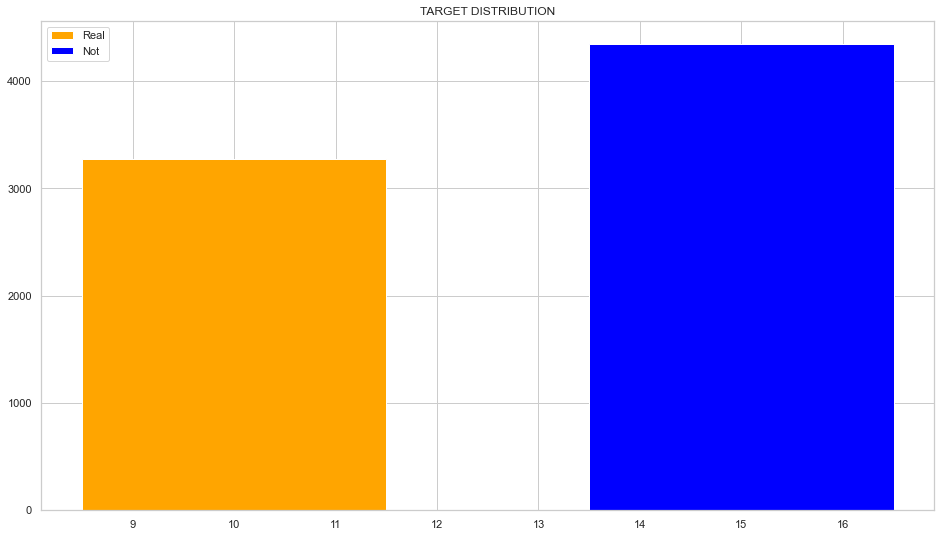

In [395]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.bar(10,full[full['target'] == 1].shape[0],3, label="Real", color='orange')
plt.bar(15,full[full['target'] == 0].shape[0],3, label="Not", color='blue')
plt.legend()
plt.title('TARGET DISTRIBUTION')
plt.show()

Here we can se an imbalance towards the negative class in dataset. 

## Sentence length analysis

In [396]:
def length(string):
    return len(string)
sent_length = full
sent_length['length'] = sent_length['text'].apply(length)
sent_length.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,88


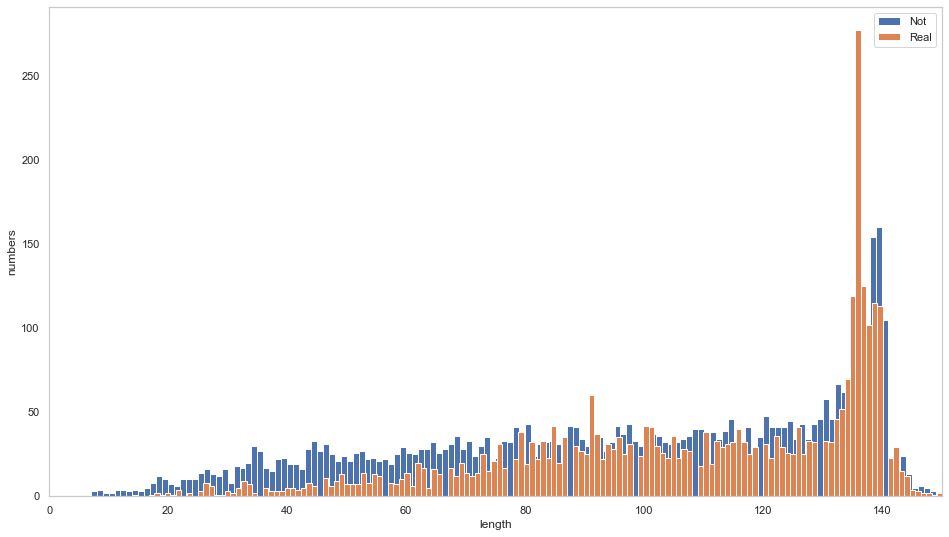

In [397]:
plt.rcParams['figure.figsize'] = (16, 9)
bins = 150
plt.hist(sent_length[sent_length['target'] == 0]['length'], alpha = 1, bins=bins, label='Not')
plt.hist(sent_length[sent_length['target'] == 1]['length'], alpha = 1, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

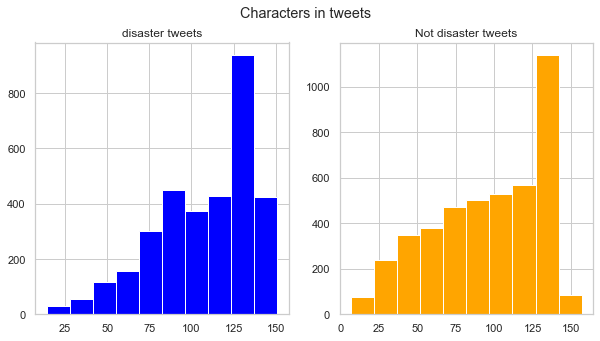

In [398]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=sent_length[sent_length['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=sent_length[sent_length['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='orange')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

## Percentage of missing values

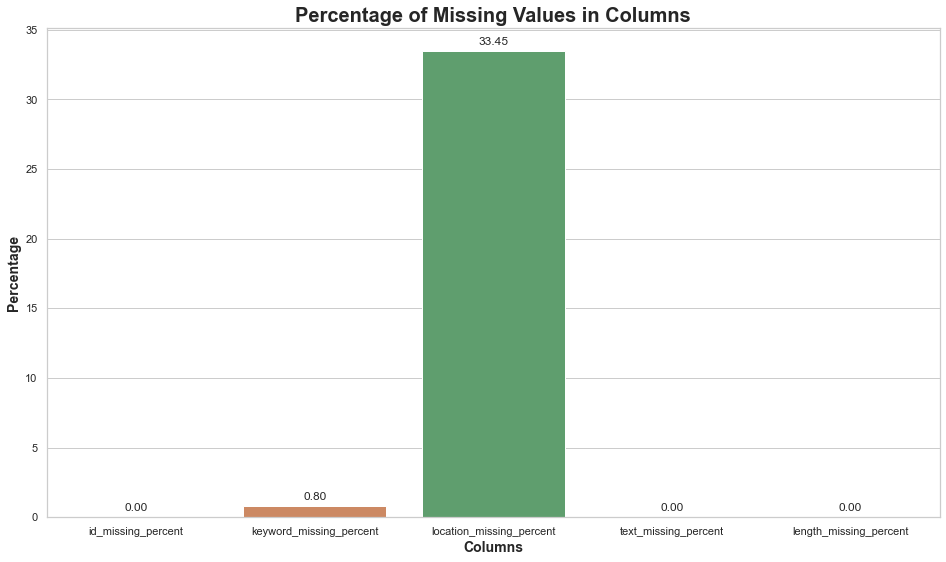

In [399]:
# creating a new dataframe for missing values percentage
missing_values = dict(zip([col+"_missing_percent" for col in full.columns if col != "target"],
                          [round(100*full[col].isnull().sum()/len(full), 2) for col in full.columns
                           if col != "target"]))
missing_values_df = pd.DataFrame(missing_values, index=[0])
missing_values_df = missing_values_df.melt(var_name= "columns", value_name= "percentage")

# plotting missing values chart
plt.figure(figsize=(16, 9))
sns.set(style="whitegrid", color_codes=True)
seaborn_plot = sns.barplot(x="columns", y="percentage", data=missing_values_df)
for p in seaborn_plot.patches:
    seaborn_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title("Percentage of Missing Values in Columns", size=20, weight="bold")
plt.xlabel("Columns", size=14, weight="bold")
plt.ylabel("Percentage", size=14, weight="bold")
plt.show()

33.45% of values in the location column are missing in the training and test set which is quite significant. Since these are locations of tweets and users on Twitter have the option of turning off their location, I’m thinking that we could possibly impute something to indicate that the location is missing. Also, due to a large number of locations being missing, we can consider removing this feature from our pipeline entirely.

## Unique values

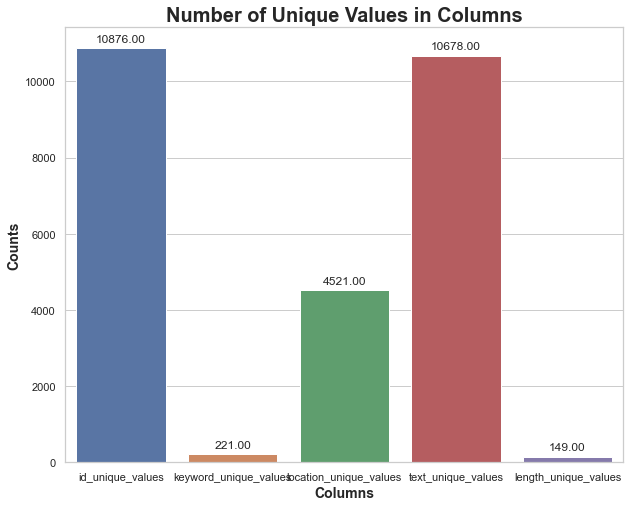

In [400]:
# creating a new dataframe for unique value cound
unique_values = dict(zip([col+"_unique_values" for col in full.columns if col != "target"],
                          [full[col].nunique() for col in full.columns if col != "target"]))
unique_values_df = pd.DataFrame(unique_values, index=[0])
unique_values_df = unique_values_df.melt(var_name= "columns", value_name= "counts")

# plotting unique values chart
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid", color_codes=True)
seaborn_plot = sns.barplot(x="columns", y="counts", data=unique_values_df)
for p in seaborn_plot.patches:
    seaborn_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title("Number of Unique Values in Columns", size=20, weight="bold")
plt.xlabel("Columns", size=14, weight="bold")
plt.ylabel("Counts", size=14, weight="bold")
plt.show()

So, there are 4521 unique locations, 221 unique keywords\
There are 198 duplicate tweets, lets investigate this

## Duplicate tweets

In [401]:
# all duplicate tweets
duplicated_df = full[full["text"].duplicated()]

print(f"Number of Duplicated Tweets in Train & Test: {len(duplicated_df)}\n\
Number of Duplicated Tweets in Train: {duplicated_df['target'].notna().sum()}\n\
Number of Duplicated Tweets in Test: {duplicated_df['target'].isna().sum()}\n")

Number of Duplicated Tweets in Train & Test: 198
Number of Duplicated Tweets in Train: 110
Number of Duplicated Tweets in Test: 88



In [402]:
# add all the tweets with duplicates
train_duplicates = train_df[train_df["text"].duplicated()].groupby(["text"])[["target"]].agg(list)

diff_label_idx = []
for idx, val in enumerate(train_duplicates["target"]):
    for ele in val: 
        if ele != val[0]:
            diff_label_idx.append(idx)
                
print(f"Number of Duplicated Tweets with different target labels in train: {len(diff_label_idx)}")

Number of Duplicated Tweets with different target labels in train: 12


In [403]:
# tweets with different labels
train_duplicates.iloc[diff_label_idx]

,target
text,
#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,"[0, 1]"
#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption,"[1, 0]"
.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,"[1, 0, 1]"
CLEARED:incident with injury:I-495 inner loop Exit 31 - MD 97/Georgia Ave Silver Spring,"[1, 0]"
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,"[1, 1, 0, 0, 0]"
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,"[1, 1, 0, 0, 0]"
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,"[1, 1, 0, 0, 0]"
Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife,"[1, 0]"
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',"[0, 1, 0, 0, 1]"


## Keywords

In [404]:
# keyword to target counts
keyword_count_df = pd.DataFrame(full.groupby(["keyword", "target"])["text"].count()).rename(columns={"text":"count"})
keyword_count_df.head(10)

count
keyword             target       
ablaze              0.0        23
                    1.0        13
accident            0.0        11
                    1.0        24
aftershock          0.0        34
airplane%20accident 0.0         5
                    1.0        30
ambulance           0.0        18
                    1.0        20
annihilated         0.0        23

## Data cleaning

In [405]:
# function to clean tweets
def clean_tweet(tweet:str) -> str:
    """
    Convert all text to lowercase, remove stock market tickers, RT symbol, hyperlinks and the hastag symbol
    :param tweet: tweet by a unique user
    :return: cleaned string without hashtags, emojis, and punctuation
    """
    # make text lower case
    tweet = tweet.lower()
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', str(tweet))
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', str(tweet))
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', str(tweet))
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', str(tweet))
    
    # remove punctuation
    punct = set(string.punctuation)
    tweet = "".join(ch for ch in tweet if ch not in punct)
    
    # remove stopwords
    stop_words = set(stopwords.words("english"))
    tweet = " ".join(word for word in tweet.split() if word not in stop_words)
    
    return tweet

In [406]:
def target_relabel(df:pd.DataFrame) -> pd.DataFrame:
    """
    Relabel duplicate tweets that are mislabelled in the training dataset
    :param df: A pandas dataframe with a "target" column
    :return: df
    """
    # manually relabel all mislabelled targets
    df.loc[df["text"]==
           "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect",
           "target"]= 0
    df.loc[df["text"]==
          "#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption",
          "target"] = 0
    df.loc[df["text"]==
          ".POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4",
          "target"] = 0
    df.loc[df["text"]==
          "CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring",
          "target"] = 1
    df.loc[df["text"]==
          "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam",
          "target"] = 0
    df.loc[df["text"]==
          "Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife",
          "target"] = 0
    df.loc[df["text"]==
          "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'",
          "target"] = 0
    df.loc[df["text"]=="To fight bioterrorism sir.", "target"] = 0
    df.loc[df["text"]==
          "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time",
          "target"] = 0
    return df

In [407]:
train = full.iloc[:len(train_df), :]
test = full.iloc[len(train_df):, :]

In [408]:
# clean tweets
train["text_clean"] = train["text"].apply(clean_tweet)
test["text_clean"] = test["text"].apply(clean_tweet)
test.tail()

,id,keyword,location,text,target,length,text_clean
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN,55,earthquake safety los angeles ûò safety faste...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN,139,storm ri worse last hurricane cityamp3others h...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN,55,green line derailment chicago
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN,65,meg issues hazardous weather outlook hwo
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,NaN,68,cityofcalgary activated municipal emergency pl...


In [409]:
# target variable 
y = train["target"].values

# initializing Kfold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)

# count vectorizer transformation
count_vect = CountVectorizer()
count_vect.fit(train["text_clean"].values.tolist() + test["text_clean"].values.tolist())
train_count_vect = count_vect.transform(train["text_clean"])

# tfidf vectorizer transformation 
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(train["text_clean"].values.tolist() + test["text_clean"].values.tolist())
train_tfidf_vect = tfidf_vect.transform(train["text_clean"])

In [410]:
# models
models= {
    "svm": SVC(),
    "logistic_regression": LogisticRegression(),
    "naive_bayes": MultinomialNB(),
    "SGD": SGDClassifier(),
    "random_forest": RandomForestClassifier()
}

# current vectors
vectors = {
    "count_vect": train_count_vect,
    "tfidf_vect": train_tfidf_vect
}

In [415]:
#    tmp_result_array = [];        
#        for i in range(len(y_preds)):
#            tmp_result_array.append(y_preds[i])
#        results["fold_{}".format(fold+1)] = f1_score(y_valid, y_preds)
#    #print(tmp_result_array)
#    print(len(tmp_result_array))
#    submit = test[['id']]
#    submit['target'] = tmp_result_array[:]
#    #print(submit.head())
#    filename=clf+"_"+vect_type+".csv"
#    submit.to_csv(filename, index = False)
#    return results
def stratified_kfold(clf:str, vect_type:str, y, kfold):
    """
    Perform Kfold Cross-Validation
    :param model: the model used to make predictions
    :param X: the train features being used 
    :param y: the target feature,
    :param kfold: the cross validation strategy
    :return: dictionary with model name key and results as the values
    """
    results = {}
    # store the name of the model in dictionary
    results["model_name"] = clf + "_" + vect_type
    
    # call the model and training data
    model = models[clf]
    X = vectors[vect_type]
    tmp = 0;
    # perfrom kfold cv
    for fold, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):
        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        # train on seen data, predict on unseen
        model.fit(X_train, y_train)
        y_preds = model.predict(y_valid)
        tmp += len(y_preds)
        results["fold_{}".format(fold+1)] = f1_score(y_valid, y_preds)
    print(tmp)
    return results

In [416]:
# store all models
all_models = []

for clf in models:
    for vect in vectors:
        print(f"Current Model: {clf}_{vect}...\n")
        all_models.append(stratified_kfold(clf, vect, y, skf))

Current Model: svm_count_vect...



ValueError: Expected 2D array, got 1D array instead:
array=[1. 1. 0. ... 1. 1. 1.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.